# Multilabel Classification of Tiger Beetles Using Deep Learning

This notebook implements taxonomic classification of tiger beetle specimens in the genus *Cicindela* using fastai and PyTorch. The approach uses a two-stage training strategy:

1. **Single-label training**: Train a model to predict the most specific taxonomic level available (species or subspecies) as a single concatenated label
2. **Multi-label transfer learning**: Transfer learned features to a multi-label model that can predict both species and subspecies separately

This methodology allows the model to learn hierarchical taxonomic relationships while handling cases where only species-level identification is possible. The approach follows methodologies established in taxonomic classification literature.

**Author**: B. de Medeiros, 2025

<div class="alert alert-info">
<strong>Note:</strong> This notebook is optimized for use with Jupyter nbextensions. 
To enable the floating table of contents, install and enable the Table of Contents (2) extension:
<pre>
pip install jupyter_contrib_nbextensions
jupyter contrib nbextension install --user
jupyter nbextension enable toc2/main
</pre>
Then refresh your Jupyter session and click the TOC icon in the toolbar.
</div>

## Setup and Dependencies

Import required libraries and configure training parameters:

In [1]:
import os, gc
from pathlib import Path
import pandas as pd
from fastai.vision.all import *
from fastai.distributed import *
from timm.loss import AsymmetricLossMultiLabel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
from collections import defaultdict, Counter
from IPython.display import display, HTML
import torch
from torch.utils.data import WeightedRandomSampler


export_path = Path("exported_fastai_models")
batch_size = 16
resize_dim = 448
n_workers = 20
arch = 'eva02_large_patch14_448.mim_m38m_ft_in22k_in1k'
#arch = 'resnet18'

os.makedirs(export_path, exist_ok=True)
%matplotlib inline

# Define the paths to your data
train_path = Path("images/train")
valid_path = Path("images/valid")
test_path = Path("images/test")

# Function to create labels from directory names
def extract_labels(dir_name):
    """
    Extract both species and subspecies labels from directory names.
    For example:
    - abbreviata_var_baliensis -> ['abbreviata', 'abbreviata_var_baliensis']
    - alba_ -> ['alba']
    """
    parts = dir_name.rstrip('_').split('_')
    species = parts[0]
    
    labels = [species]
    if len(parts) > 1:
        # Include the full name as a subspecies label
        subspecies = '_'.join(parts)
        labels.append(subspecies)
    
    return labels

# Function to create a dataframe with file paths and labels
def create_dataframe(data_path):
    rows = []
    
    for dir_name in os.listdir(data_path):
        # Skip any non-directory items or cache files
        if not os.path.isdir(data_path/dir_name) or dir_name == 'labels.cache':
            continue
            
        # Get the labels for this directory
        labels = extract_labels(dir_name)
        
        # Get all image files in the directory
        img_files = list(Path(data_path/dir_name).glob('*.*'))
        for img_file in img_files:
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                rows.append({
                    'path': img_file,
                    'labels': labels
                })
    
    return pd.DataFrame(rows)

def remove_redundant_subspecies(df):
    """
    Process the dataframe to remove redundant subspecies labels.
    
    A subspecies is considered redundant if:
    1. All instances of a species that have a subspecies label have the SAME subspecies
    2. The species always has a subspecies (no records with just the species)
    
    Args:
        df: DataFrame with a 'labels' column containing semicolon-separated labels
        
    Returns:
        DataFrame with redundant subspecies labels removed
    """
    # Create mappings to track species and their subspecies
    species_to_subspecies = {}  # Map species to set of associated subspecies
    species_counts = {}         # Count total occurrences of each species
    species_with_subspecies = {}  # Count how often a species has a subspecies
    
    # Process each row to build the mappings
    for _, row in df.iterrows():
        labels = row['labels']
        species = labels[0]
        
        # Update total species count
        species_counts[species] = species_counts.get(species, 0) + 1
        
        # If there's a subspecies, track it
        if len(labels) > 1:
            subspecies = labels[1]
            
            # Update subspecies tracking
            if species not in species_to_subspecies:
                species_to_subspecies[species] = set()
            species_to_subspecies[species].add(subspecies)
            
            # Update count of species with subspecies
            species_with_subspecies[species] = species_with_subspecies.get(species, 0) + 1
    
    # Find truly redundant subspecies (single subspecies AND all instances have it)
    redundant_subspecies = {}
    for species, subspecies_set in species_to_subspecies.items():
        # Check if this species only has one subspecies
        if len(subspecies_set) == 1:
            # Check if all instances of this species have a subspecies
            if species_counts[species] == species_with_subspecies[species]:
                redundant_subspecies[species] = next(iter(subspecies_set))
    
    # Process the dataframe to remove redundant subspecies
    updated_df = df.copy()
    
    for idx, row in updated_df.iterrows():
        labels = row['labels']
        
        if len(labels) > 1:
            species = labels[0]
            subspecies = labels[1]
            
            # If this is a redundant subspecies, remove it
            if species in redundant_subspecies and subspecies == redundant_subspecies[species]:
                updated_df.at[idx, 'labels'] = [species]
    
    # Print summary of removed redundant subspecies
    if redundant_subspecies:
        print(f"Removed {len(redundant_subspecies)} redundant subspecies labels:")
        for species, subspecies in redundant_subspecies.items():
            print(f"  - {subspecies} (always associated with {species})")
    else:
        print("No redundant subspecies labels found.")
        
    return updated_df

## Data Organization and Label Processing

This section sets up the data processing pipeline and generates dataset statistics:

1. **Directory structure**: Images are organized in subdirectories named by taxonomic labels (e.g., "repanda_repanda", "sexguttata")
2. **Label extraction**: The `extract_labels()` function creates hierarchical labels from directory names:
   - Single names (e.g., "sexguttata") → species only: ["sexguttata"]  
   - Compound names (e.g., "repanda_repanda") → species + subspecies: ["repanda", "repanda_repanda"]
3. **Redundancy removal**: `remove_redundant_subspecies()` eliminates subspecies labels that provide no additional information beyond the species name
4. **Data merging**: Training and validation sets are combined with an `is_valid` flag for splitting
5. **Dataset analysis**: Print comprehensive statistics including label distribution, class imbalance, and sample verification

In [2]:
# Create dataframes for train and validation sets
train_df = create_dataframe(train_path)
valid_df = create_dataframe(valid_path)

# Combine into a single dataframe with a 'is_valid' column for splitting
df = pd.concat([
    train_df.assign(is_valid=False),
    valid_df.assign(is_valid=True)
], ignore_index=True)

# Remove redundant subspecies
df = remove_redundant_subspecies(df)

# ----- Add these statistics printing sections -----

# Print basic dataset statistics
print(f"Total images: {len(df)}")
print(f"Training images: {len(df[~df['is_valid']])}")
print(f"Validation images: {len(df[df['is_valid']])}")

# Expand the labels column into a list for analysis
all_labels = []
for label_str in df['labels']:
    all_labels.extend(label_str)

# Count unique labels
unique_labels = pd.Series(all_labels).unique()
print(f"Total unique labels: {len(unique_labels)}")
print(f"Species labels: {len([l for l in unique_labels if '_' not in l])}")
print(f"Subspecies labels: {len([l for l in unique_labels if '_' in l])}")

# Show label distribution
label_counts = pd.Series(all_labels).value_counts()
print("\nTop 10 most common labels:")
print(label_counts.head(10))
print("\nBottom 10 least common labels:")
print(label_counts.tail(10))

# Print examples of labels for verification
print("\nSample of extracted labels for verification:")
sample_rows = df.sample(min(5, len(df)))
for _, row in sample_rows.iterrows():
    print(f"Path: {row['path'].name}, Labels: {row['labels']}")

# Check for extreme cases - species with many or few images
species_counts = pd.Series([l.split('_')[0] for l in all_labels]).value_counts()
print("\nSpecies with most images:")
print(species_counts.head(5))
print("\nSpecies with fewest images:")
print(species_counts.tail(5))

# ----- End of statistics section -----

Removed 8 redundant subspecies labels:
  - princeps_ducalis (always associated with princeps)
  - aurulenta_aurulenta (always associated with aurulenta)
  - lacteola_lacteola (always associated with lacteola)
  - roseiventris_mexicana (always associated with roseiventris)
  - coerulea_nitida (always associated with coerulea)
  - clypeata_clypeata (always associated with clypeata)
  - varians_lecontei (always associated with varians)
  - soluta_soluta (always associated with soluta)
Total images: 6279
Training images: 4883
Validation images: 1396
Total unique labels: 248
Species labels: 141
Subspecies labels: 107

Top 10 most common labels:
repanda             644
punctulata          642
repanda_repanda     461
sexguttata          421
formosa             355
scutellaris         355
oregona             343
oregona_oregona     281
ocellata            257
formosa_generosa    245
Name: count, dtype: int64

Bottom 10 least common labels:
dysenterica                    1
hydrophoba_atroreduct

## Single-Label DataBlock Configuration

Configure the data processing pipeline for single-label training:

- **CategoryBlock**: Uses single categorical labels (concatenated most specific taxonomic level)
- **Image preprocessing**: Resize to 448px with padding and dihedral augmentation (rotation/flipping)
- **Batch augmentation**: Geometric transformations (rotation, zoom, warp) and photometric changes (lighting)
- **Normalization**: Uses ImageNet statistics for pretrained model compatibility
- **No horizontal flipping**: Preserves left/right asymmetry important for taxonomic identification

The concatenated labels (e.g., "repanda_repanda") allow the model to learn relationships between species and subspecies levels.

In [3]:
# Define the DataBlock
dblock_sl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('path'),
    get_y=ColReader('labels'),
    splitter=ColSplitter('is_valid'),
    item_tfms=[Resize(resize_dim, method='pad', pad_mode='border'),
               DihedralItem(p=0.5)],
    batch_tfms=[
        *aug_transforms(do_flip=False, 
                        max_rotate=45, 
                        max_zoom=1.1,
                        min_zoom=0.9,
                        max_warp=0.1,
                        max_lighting=0.3, 
                        p_lighting=0.2,
                        p_affine=0.2,
                        pad_mode='border'),
        Normalize.from_stats(*imagenet_stats)
    ]
)

## Class Balancing Through Weighted Sampling

Address severe class imbalance using weighted sampling with detailed analysis:

1. **Weight calculation**: Compute inverse frequency weights for each label using square root scaling to prevent extreme values
2. **Sample weighting**: For multi-label samples, use the mean weight of constituent labels
3. **Normalization**: Scale weights so the minimum weight equals 1.0
4. **Statistics reporting**: Print individual label weights and sample weight distribution

This approach up-samples rare species/subspecies during training while down-sampling common ones, helping the model learn from all taxonomic groups. The square root scaling prevents extreme upweighting of very rare classes.

In [4]:
# Calculate multilabel-aware weights
def calculate_multilabel_weights_for_weighted_dl(df):
    # Get training data only
    train_df = df[df['is_valid'] == False].copy()
    
    # Count frequency of each individual label across all samples
    all_labels = []
    for label_list in train_df['labels']:
        for label in label_list:
            if label == 'a':
                print(label_list)
                break
        all_labels.extend(label_list)
        
    
    print("a" in all_labels)
    print(label_counts)
    total_samples = len(train_df)
    
    # Calculate inverse frequency weights for each label
    label_weights = {}
    for label, count in label_counts.items():
        label_weights[label] = np.sqrt(total_samples / count)
    
    # Normalize weights to prevent extreme values
    min_weight = min(label_weights.values())
    label_weights = {k: v/min_weight for k, v in label_weights.items()}
    
    print("Individual label weights:")
    for label, weight in sorted(label_weights.items(), key=lambda x: x[1]):
        count = label_counts[label]
        print(f"  {label}: {count} occurrences (weight: {weight:.3f})")
    
    # Calculate sample weights (mean of constituent label weights)
    sample_weights = []
    for label_list in train_df['labels']:
        sample_label_weights = [label_weights[label] for label in label_list]
        sample_weight = np.mean(sample_label_weights)
        sample_weights.append(sample_weight)
    
    print(f"\nSample weight stats:")
    print(f"  Min: {min(sample_weights):.3f}")
    print(f"  Max: {max(sample_weights):.3f}")
    print(f"  Mean: {np.mean(sample_weights):.3f}")
    print(f"  Number of weights: {len(sample_weights)}")
    
    return sample_weights

# Calculate weights based on original multilabel data
sample_weights = calculate_multilabel_weights_for_weighted_dl(df)



False
repanda                        644
punctulata                     642
repanda_repanda                461
sexguttata                     421
formosa                        355
                              ... 
carthagena_colossea              1
tranquebarica_parallelonota      1
parowana_wallisi                 1
klugii                           1
nigrocoerulea_bowditchi          1
Name: count, Length: 248, dtype: int64
Individual label weights:
  repanda: 644 occurrences (weight: 1.000)
  punctulata: 642 occurrences (weight: 1.002)
  repanda_repanda: 461 occurrences (weight: 1.182)
  sexguttata: 421 occurrences (weight: 1.237)
  formosa: 355 occurrences (weight: 1.347)
  scutellaris: 355 occurrences (weight: 1.347)
  oregona: 343 occurrences (weight: 1.370)
  oregona_oregona: 281 occurrences (weight: 1.514)
  ocellata: 257 occurrences (weight: 1.583)
  formosa_generosa: 245 occurrences (weight: 1.621)
  tranquebarica: 245 occurrences (weight: 1.621)
  trifasciata: 241 occurrence

In [5]:
# Prepare the processed dataframe
df_processed = df.assign(labels=df['labels'].apply(lambda x: '_'.join(x)))

# Create weighted dataloaders directly using DataBlock.weighted_dataloaders()
dls_sl = dblock_sl.weighted_dataloaders(
    df_processed,           # source data 
    wgts=sample_weights,    # weights for training samples
    bs=batch_size,
    num_workers=n_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=6
)

print(f"\nCreated weighted dataloaders with {len(sample_weights)} weighted training samples")


Created weighted dataloaders with 4883 weighted training samples


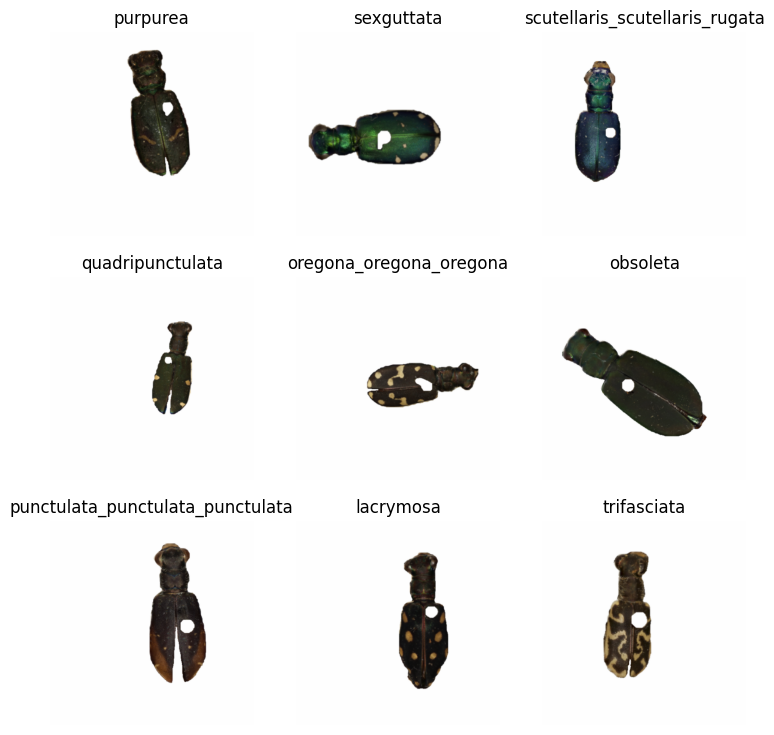

In [6]:
# Display a batch of training images with their labels
dls_sl.show_batch()

## Single-Label Model Training

Train the initial single-label model:

1. **Architecture**: Vision transformer (EVA02-Large) pretrained on ImageNet
2. **Optimization**: Mixed precision training (`to_fp16()`) and multi-GPU parallelization for efficiency
3. **Regularization**: MixUp augmentation to improve generalization
4. **Metrics**: Standard accuracy and balanced accuracy to handle class imbalance

This model learns to classify each image with its most specific taxonomic label (species or subspecies).

In [7]:
# Create the vision learner
learn_sl = vision_learner(dls_sl, 
                      arch,
                      metrics=[accuracy, BalancedAccuracy()],
                      cbs=[MixUp()]).to_fp16().to_parallel(device_ids=[0,1])

## Learning Rate Optimization

Use fastai's learning rate finder to automatically determine optimal learning rate:

1. **Frozen training**: Freeze pretrained backbone layers to train only the classification head
2. **LR finder**: Test a range of learning rates to find the steepest descent in the loss curve
3. **Valley selection**: Choose the learning rate at the "valley" of the loss curve for stable training

The LR finder prevents using learning rates that are too high (causing divergence) or too low (causing slow convergence).

/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


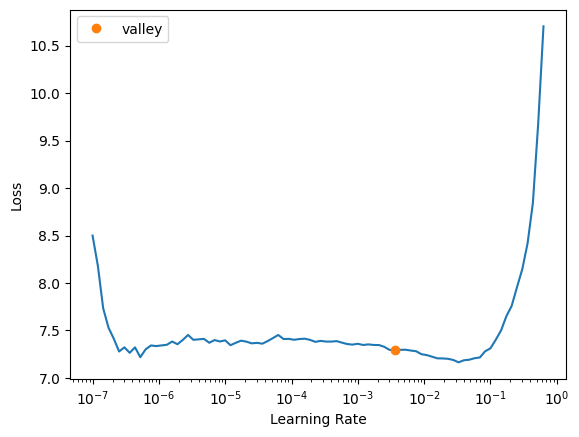

In [8]:
# Freeze the pretrained layers
learn_sl.freeze()

# Find optimal learning rate
base_lr = learn_sl.lr_find()

## Fine-Tuning Strategy

Implement progressive unfreezing for optimal transfer learning:

1. **Frozen epochs**: Train classification head for 5 epochs with backbone frozen
2. **Full fine-tuning**: Unfreeze entire model and train for 5 more epochs
3. **Parallel processing**: Detach from multi-GPU mode after training for inference compatibility

In [9]:
# Fine-tune the model
learn_sl.fine_tune(epochs=5, freeze_epochs=5, base_lr=base_lr.valley)

# After training, detach from parallel mode for inference
learn_sl.detach_parallel()

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,5.590012,3.086874,0.399713,0.135376,05:23
1,3.891883,1.782437,0.580229,0.288918,05:30
2,2.977797,1.492722,0.606017,0.386862,05:21
3,2.733079,1.227558,0.690544,0.459018,05:29
4,2.347007,1.223858,0.716332,0.513215,05:36


/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/m

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.112560,1.090238,0.704155,0.492637,06:33
1,2.052730,1.051052,0.696991,0.492605,06:28
2,1.706820,0.749158,0.780086,0.580253,06:32
3,1.438241,0.620929,0.807307,0.654882,06:38
4,1.355440,0.590928,0.820917,0.668999,06:35


/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/m

## Model Export and Memory Management

Save the trained single-label model for later use and clean up memory:

In [10]:
learn_sl.export(export_path/f"{arch}_sl.pkl")
del(learn_sl, dls_sl, dblock_sl)

## Multi-Label Model Setup and Transfer Learning

Configure and initialize the multi-label model with transfer learning:

1. **Architecture change**: Switch from CategoryBlock to MultiCategoryBlock for multi-label classification
2. **Loss function**: Use AsymmetricLossMultiLabel optimized for imbalanced multi-label problems (gamma_neg=2, gamma_pos=2)
3. **Metrics**: Micro-averaged precision, recall, and ROC-AUC for multi-label evaluation
4. **Transfer learning**: Load the trained single-label model and transfer compatible weights
5. **Weight filtering**: Only transfer layers with matching dimensions between single-label and multi-label models
6. **Mixed precision**: Use fp16 training and multi-GPU parallelization for efficiency

This leverages the hierarchical features learned in single-label training for multi-label prediction, allowing the model to predict both species and subspecies independently.

In [5]:
# Define the DataBlock
learn_sl = load_learner(export_path/f"{arch}_sl.pkl").detach_parallel()

dblock_ml = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader('path'),
    get_y=ColReader('labels'),
    splitter=ColSplitter('is_valid'),
    item_tfms=[Resize(resize_dim, method='pad', pad_mode='border'),
               DihedralItem(p=0.5)],
    batch_tfms=[
        *aug_transforms(do_flip=False, 
                        max_rotate=45, 
                        max_zoom=1.1,
                        min_zoom=0.9,
                        max_warp=0.1,
                        max_lighting=0.3, 
                        p_lighting=0.5,
                        p_affine=0.3,
                        pad_mode='border'),
        Normalize.from_stats(*imagenet_stats)
    ]
)

dls_ml = dblock_ml.weighted_dataloaders(df, 
                                        wgts = sample_weights,
                               bs=batch_size, 
                               num_workers=n_workers,
                               pin_memory=True,
                               persistent_workers=True,
                               prefetch_factor=6)

learn_ml = vision_learner(dls_ml, 
                      arch,
                      metrics=[PrecisionMulti(average='micro', thresh=0.5),
                              RecallMulti(average='micro', thresh=0.5),
                              RocAuc(average='micro')],
                      loss_func=AsymmetricLossMultiLabel(gamma_neg=2,
                                                        gamma_pos=2,
                                                        clip=0.05),
                      cbs=[MixUp()])



source_state_dict = learn_sl.model.state_dict()
target_state_dict = learn_ml.model.state_dict()

# Only load layers with matching shapes
filtered_state_dict = {}
for k, v in source_state_dict.items():
    if k in target_state_dict and target_state_dict[k].shape == v.shape:
        filtered_state_dict[k] = v

learn_ml.model.load_state_dict(filtered_state_dict, strict=False)
learn_ml.to_fp16().to_parallel(device_ids=[0,1])

del(learn_sl)
gc.collect()
torch.cuda.empty_cache()

/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


## Multi-Label Model Training

Train the multi-label model using transferred features:

1. **Progressive training**: Freeze backbone for 3 epochs, then unfreeze for 10 epochs of fine-tuning
2. **Learning rate optimization**: Use LR finder to determine optimal learning rate for multi-label training
3. **AsymmetricLoss**: Specialized loss function handles positive/negative class imbalance in multi-label setting
4. **Memory management**: Clean up single-label model after weight transfer

/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


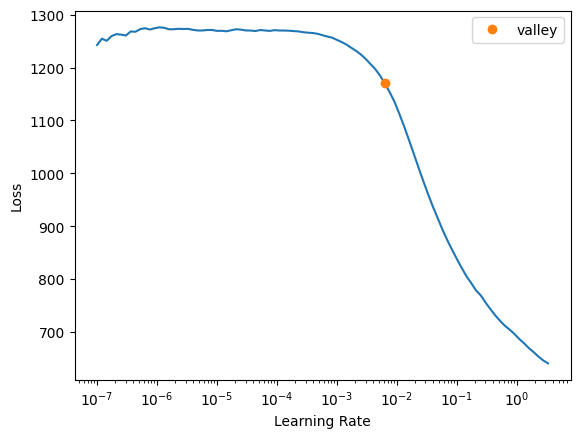

In [6]:
# Freeze the pretrained layers
learn_ml.freeze()

# Find optimal learning rate
base_lr = learn_ml.lr_find()

In [7]:
# Fine-tune the model
learn_ml.fine_tune(epochs=10, freeze_epochs=3, base_lr=base_lr.valley)

# After training, detach from parallel mode for inference
learn_ml.detach_parallel()

epoch,train_loss,valid_loss,precision_score,recall_score,roc_auc_score,time
0,71.404938,11.742498,0.929825,0.479855,0.981977,05:35
1,11.090961,6.098943,0.871551,0.829335,0.997633,05:36
2,10.574513,7.084305,0.858919,0.813038,0.996654,05:35


/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,precision_score,recall_score,roc_auc_score,time
0,7.006996,5.544238,0.882407,0.869624,0.997857,06:25
1,9.269782,7.279872,0.824242,0.800362,0.996302,06:29
2,7.924570,6.311383,0.841437,0.869624,0.997438,06:25
3,6.970223,5.764060,0.850337,0.856496,0.997830,06:27
4,6.059558,4.427758,0.892408,0.867361,0.998283,06:31
5,5.059512,4.576102,0.902214,0.885469,0.998160,06:28
6,4.124606,4.210985,0.884649,0.913083,0.998027,06:30
7,3.400928,4.056765,0.918329,0.895880,0.998529,06:30
8,3.042049,3.965177,0.897869,0.915346,0.998454,06:38
9,2.999653,3.847873,0.910072,0.916252,0.998644,06:44


## Export Multi-Label Model

Save the final trained multi-label model:

In [8]:
learn = learn_ml
learn.export(export_path/f"{arch}_ml.pkl")
del(learn_ml, dls_ml, dblock_ml)
gc.collect()
torch.cuda.empty_cache()

## Test Set Evaluation Setup

Prepare the held-out test set for final model evaluation:

1. **Model loading**: Load the trained multi-label model from disk
2. **Test data processing**: Apply same label extraction and processing pipeline to test images
3. **Vocabulary filtering**: Ensure test labels match the model's vocabulary (remove any unseen labels)
4. **Test dataloader**: Create dataloader with labels for metric calculation
5. **Prediction generation**: Get model predictions with sigmoid activation for multi-label output

In [9]:
learn = load_learner(export_path/f"{arch}_ml.pkl", cpu=False)

test_df = create_dataframe(test_path)

vocab_list = learn.dls.vocab
def filter_labels(label_list, vocab):
    return [label for label in label_list if label in vocab]
test_df['labels'] = test_df['labels'].apply(lambda x: filter_labels(x, vocab_list))
test_df['is_valid'] = True

test_dl = learn.dls.test_dl(test_df, with_labels = True)

/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


## Test Set Predictions

Generate model predictions on the test set using sigmoid activation for multi-label classification. These predictions will be used for detailed performance analysis.

In [10]:
# Get predictions and targets
preds, targs = learn.get_preds(dl = test_dl, with_loss=False, with_targs=True, act = torch.sigmoid)

/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


## Detailed Performance Analysis by Taxonomic Class

Calculate comprehensive evaluation metrics for each taxonomic class:

1. **Threshold application**: Convert continuous predictions to binary decisions using 0.5 threshold
2. **Per-class metrics**: Calculate precision, recall, true positives, false positives, and false negatives for each taxonomic term
3. **Training set integration**: Include training set counts to understand data availability effects on performance
4. **Confusion analysis**: Identify which classes are commonly confused (false positives) with each other
5. **Results table**: Create publication-ready DataFrame with performance metrics, sorted by precision
6. **Styled output**: Generate formatted HTML table with color-coded performance metrics

This analysis reveals model performance across the taxonomic hierarchy and identifies challenging classification cases, providing insights into which species/subspecies are most difficult to distinguish.

In [11]:
pred_threshold = 0.5
# Get vocabulary
vocab = learn.dls.vocab
if isinstance(vocab, list):
    vocab = vocab[-1]  # As in ClassificationInterpretation.__init__

# Get training set counts for each term from train_df
train_counts = {}

# Initialize counts for all classes
for i in range(len(vocab)):
    train_counts[i] = 0

# Count occurrences in training DataFrame
for labels_list in train_df['labels']:
    # Convert string representation to actual list if needed
    if isinstance(labels_list, str):
        # Remove brackets and quotes, then split
        labels_list = labels_list.strip('[]').replace("'", "").split(', ')
    
    # Count each label
    for label in labels_list:
        label = label.strip()  # Remove any whitespace
        # Use vocab.o2i to get the index instead of .index()
        if hasattr(vocab, 'o2i') and label in vocab.o2i:
            idx = vocab.o2i[label]
            train_counts[idx] += 1
        elif label in vocab:
            # Fallback if o2i doesn't exist
            for i, v in enumerate(vocab):
                if v == label:
                    train_counts[i] += 1
                    break

# Determine if this is multi-label or multi-class
is_multilabel = len(targs.shape) > 1

# Convert tensors to numpy
preds_np = preds.cpu().numpy()
targs_np = targs.cpu().numpy()

# For multi-label, threshold predictions
if is_multilabel:
    preds_binary = (preds_np > pred_threshold).astype(int)
else:
    # For multi-class, convert to one-hot encoding
    preds_binary = np.zeros_like(preds_np)
    for i in range(len(preds_np)):
        preds_binary[i, np.argmax(preds_np[i])] = 1

# Dictionary to track confusions
confusions = defaultdict(list)

# Calculate confusions - for each sample, identify false positives when true labels are present
for i in range(len(targs_np)):
    if is_multilabel:
        # For each sample, get true labels and predicted labels
        true_labels = np.where(targs_np[i] == 1)[0]
        pred_labels = np.where(preds_binary[i] == 1)[0]
        
        # For each true label, find false positives
        for true_idx in true_labels:
            false_pos_indices = [idx for idx in pred_labels if idx != true_idx and idx not in true_labels]
            if false_pos_indices:  # If there are false positives
                confusions[true_idx].extend(false_pos_indices)
    else:
        # For multi-class, the true label is confused with the predicted label if they differ
        true_label = np.argmax(targs_np[i]) if len(targs_np.shape) > 1 else targs_np[i]
        pred_label = np.argmax(preds_np[i])
        if true_label != pred_label:
            confusions[true_label].append(pred_label)

# Create a list to store results
results = []

# Calculate metrics for each class
for i in range(preds.shape[1]):
    # Get class name
    if i < len(vocab):
        class_name = vocab[i]
    else:
        class_name = f"Class_{i}"
    
    # Extract binary predictions and targets for this class
    if is_multilabel:
        pred_i = preds_binary[:, i]
        targ_i = targs_np[:, i]
    else:
        # For multi-class, create one-hot encoding
        pred_i = (np.argmax(preds_np, axis=1) == i).astype(int)
        targ_i = (targs_np == i).astype(int) if len(targs_np.shape) == 1 else (np.argmax(targs_np, axis=1) == i).astype(int)
    
    # Calculate N (number of samples with this label in test/validation set)
    N = targ_i.sum()
    
    # Get training count for this class
    N_train = int(train_counts.get(i, 0))
    
    # Skip if N is zero
    if N == 0:
        continue
    
    # Calculate metrics
    true_positives = np.sum((pred_i == 1) & (targ_i == 1))
    false_positives = np.sum((pred_i == 1) & (targ_i == 0))
    false_negatives = np.sum((pred_i == 0) & (targ_i == 1))
    
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 1
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    
    # Process confusions for this class
    confused_with = []
    if i in confusions and confusions[i]:
        # Count occurrences of each confusion
        confusion_counts = {}
        for idx in confusions[i]:
            if idx < len(vocab):
                label = vocab[idx]
                confusion_counts[label] = confusion_counts.get(label, 0) + 1
            else:
                label = f"Class_{idx}"
                confusion_counts[label] = confusion_counts.get(label, 0) + 1
        
        # Sort by count and format as "label (count)"
        confused_with = [f"{label} ({count})" for label, count in 
                         sorted(confusion_counts.items(), key=lambda x: x[1], reverse=True)]
    
    # Add to results
    results.append({
        'Term': class_name,
        'N_train': N_train,
        'N': int(N),
        'micro_precision': precision,
        'micro_recall': recall,
        'true_positives': int(true_positives),
        'false_positives': int(false_positives),
        'false_negatives': int(false_negatives),
        'confused_with': ', '.join(confused_with) if confused_with else ''
    })

# Create DataFrame and sort by micro_precision first, then by N (both descending)
df = pd.DataFrame(results)
df = df.sort_values(['micro_precision', 'N'], ascending=[False, False])

# Format DataFrame for display
pd.set_option('display.float_format', '{:.4f}'.format)  # Format floats to 4 decimal places

# Format precision and recall as percentages
df['micro_precision'] = df['micro_precision'] * 100
df['micro_recall'] = df['micro_recall'] * 100

# Create a styled version of the DataFrame
from IPython.display import display, HTML

# Style the DataFrame
styled_df = df.style.format({
    'N_train': '{:,d}',
    'N': '{:,d}',
    'micro_precision': '{:.2f}%',
    'micro_recall': '{:.2f}%',
    'true_positives': '{:,d}',
    'false_positives': '{:,d}',
    'false_negatives': '{:,d}'
}).background_gradient(subset=['micro_precision', 'micro_recall'], cmap='RdYlGn')

# Add a title and display
display(HTML("<h2>Model Performance by Term</h2>"))
display(styled_df)

,Term,N_train,N,micro_precision,micro_recall,true_positives,false_positives,false_negatives,confused_with
126,punctulata,500,74,100.00%,100.00%,74,0,0,punctulata_punctulata (7)
134,repanda,501,73,100.00%,98.63%,72,0,1,repanda_repanda (19)
115,oregona,267,44,100.00%,95.45%,42,0,2,"oregona_oregona (5), oregona_guttifera (1), oregona_guttifera_x_(Cicindela)_oregona_navajoensis (1), depressula (1)"
47,formosa,276,42,100.00%,100.00%,42,0,0,"formosa_formosa (4), formosa_generosa (1)"
172,tranquebarica,191,31,100.00%,100.00%,31,0,0,tranquebarica_tranquebarica (7)
111,ocellata,200,30,100.00%,90.00%,27,0,3,"hemorrhagica (2), hemorrhagica_hemorrhagica (2), sedecimpunctata (1), sedecimpunctata_sedecimpunctata (1)"
177,trifasciata,188,30,100.00%,100.00%,30,0,0,"trifasciata_peruviana (4), trifasciata_ascendens (1), trifasciata_trifasciata (1), trifasciata_sigmoidea (1)"
62,hirticollis,176,29,100.00%,100.00%,29,0,0,"hirticollis_hirticollis (5), hirticollis_gravida (1)"
128,purpurea,125,22,100.00%,95.45%,21,0,1,"purpurea_audubonii (3), limbalis (1), purpurea_cimarrona (1)"
112,ocellata_ocellata,101,15,100.00%,86.67%,13,0,2,"hemorrhagica (1), hemorrhagica_hemorrhagica (1), sedecimpunctata (1), sedecimpunctata_sedecimpunctata (1)"


In [12]:
df.to_csv(f"test_results_{arch}.csv")

## Evaluation on Unknown Specimens

Apply the trained model to classify unknown specimens from the `unknowns/` directory:

1. **Unknown data preparation**: Load unlabeled images from the unknowns folder
2. **Model inference**: Generate predictions using the trained multi-label model
3. **Binary classification**: Apply 0.5 threshold to convert probabilities to taxonomic assignments
4. **Label decoding**: Convert model outputs back to taxonomic names for interpretation

This demonstrates practical application of the model to real taxonomic identification tasks.

In [ ]:
unknown_df = pd.DataFrame({'path':get_image_files('unknowns'),'labels':None,'is_valid':True})
test_dl = learn.dls.test_dl(unknown_df, with_labels = False)
unknown_preds, _ = learn.get_preds(dl = test_dl, with_loss=False, with_targs=False, act=torch.sigmoid)

/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/bdemedeiros/software/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


In [ ]:
# Convert predictions to binary predictions
binary_preds = (unknown_preds > 0.5).int()

# Use fastai's decode method if available
try:
    pred_labels = [learn.dls.decode(row) for row in binary_preds]
    unknown_df['predictions'] = pred_labels
except:
    # Fallback to manual method
    pred_labels = []
    for row in binary_preds:
        indices = torch.nonzero(row, as_tuple=True)[0]
        labels = [learn.dls.vocab[i] for i in indices.tolist()]
        pred_labels.append(labels)
    unknown_df['predictions'] = pred_labels

In [ ]:
unknown_df